# Model Training and Evaluation
## Train multiple classification models and select the best one

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Try to import CatBoost, but continue if not available
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️  CatBoost not available - will train 8 models instead of 9")

import joblib
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

C:\Users\kanch\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


⚠️  CatBoost not available - will train 8 models instead of 9


True

In [2]:
#pip install lightgbm

## 1. Load and Prepare Data

In [3]:
# Load data
df = pd.read_csv('extracted_documents.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())

Dataset shape: (53, 4)

Category distribution:
category
React Developer    21
SQL Developer      11
Workday            11
Peoplesoft         10
Name: count, dtype: int64


In [4]:
# Text preprocessing
def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("Text preprocessing completed")

Text preprocessing completed


In [5]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

print("\nLabel Encoding:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{i}: {category}")

# Save label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("\nLabel encoder saved")


Label Encoding:
0: Peoplesoft
1: React Developer
2: SQL Developer
3: Workday

Label encoder saved


## 2. Feature Extraction

In [6]:
# Split data - stratified to maintain class distribution
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts())

Training set size: 42
Test set size: 11

Training set distribution:
label
1    16
3     9
2     9
0     8
Name: count, dtype: int64

Test set distribution:
label
1    5
0    2
3    2
2    2
Name: count, dtype: int64


In [7]:
# TF-IDF Vectorization
# Term Frequency-Inverse Document Frequency
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Save vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("Vectorizer saved")

TF-IDF feature shape: (42, 3183)
Vectorizer saved


## 3. Model Training and Evaluation

In [8]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# Add CatBoost only if available
if CATBOOST_AVAILABLE:
    models['CatBoost'] = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
    print(f"Training {len(models)} models (including CatBoost)...\n")
else:
    print(f"Training {len(models)} models (CatBoost not available)...\n")

Training 8 models (CatBoost not available)...



In [9]:
# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print()

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

Training Naive Bayes...
  Accuracy: 0.8182
  F1-Score: 0.8030
  CV Score: 0.9528 (+/- 0.0580)

Training Logistic Regression...
  Accuracy: 0.9091
  F1-Score: 0.8981
  CV Score: 0.9528 (+/- 0.0580)

Training SVM...
  Accuracy: 1.0000
  F1-Score: 1.0000
  CV Score: 0.9528 (+/- 0.0580)

Training Decision Tree...
  Accuracy: 1.0000
  F1-Score: 1.0000
  CV Score: 0.8361 (+/- 0.1160)

Training Random Forest...
  Accuracy: 1.0000
  F1-Score: 1.0000
  CV Score: 0.9528 (+/- 0.0580)

Training Gradient Boosting...
  Accuracy: 1.0000
  F1-Score: 1.0000
  CV Score: 1.0000 (+/- 0.0000)

Training XGBoost...
  Accuracy: 0.9091
  F1-Score: 0.8981
  CV Score: 0.8083 (+/- 0.0611)

Training LightGBM...
  Accuracy: 1.0000
  F1-Score: 1.0000
  CV Score: 0.3833 (+/- 0.0612)


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  CV Mean   CV Std
                SVM  1.000000   1.000000 1.000000  1.000000 0.952778 0.058002
      Decision Tree  1.000000   1.000000 1.000000  1.000000 0.8

## 4. Visualize Model Performance

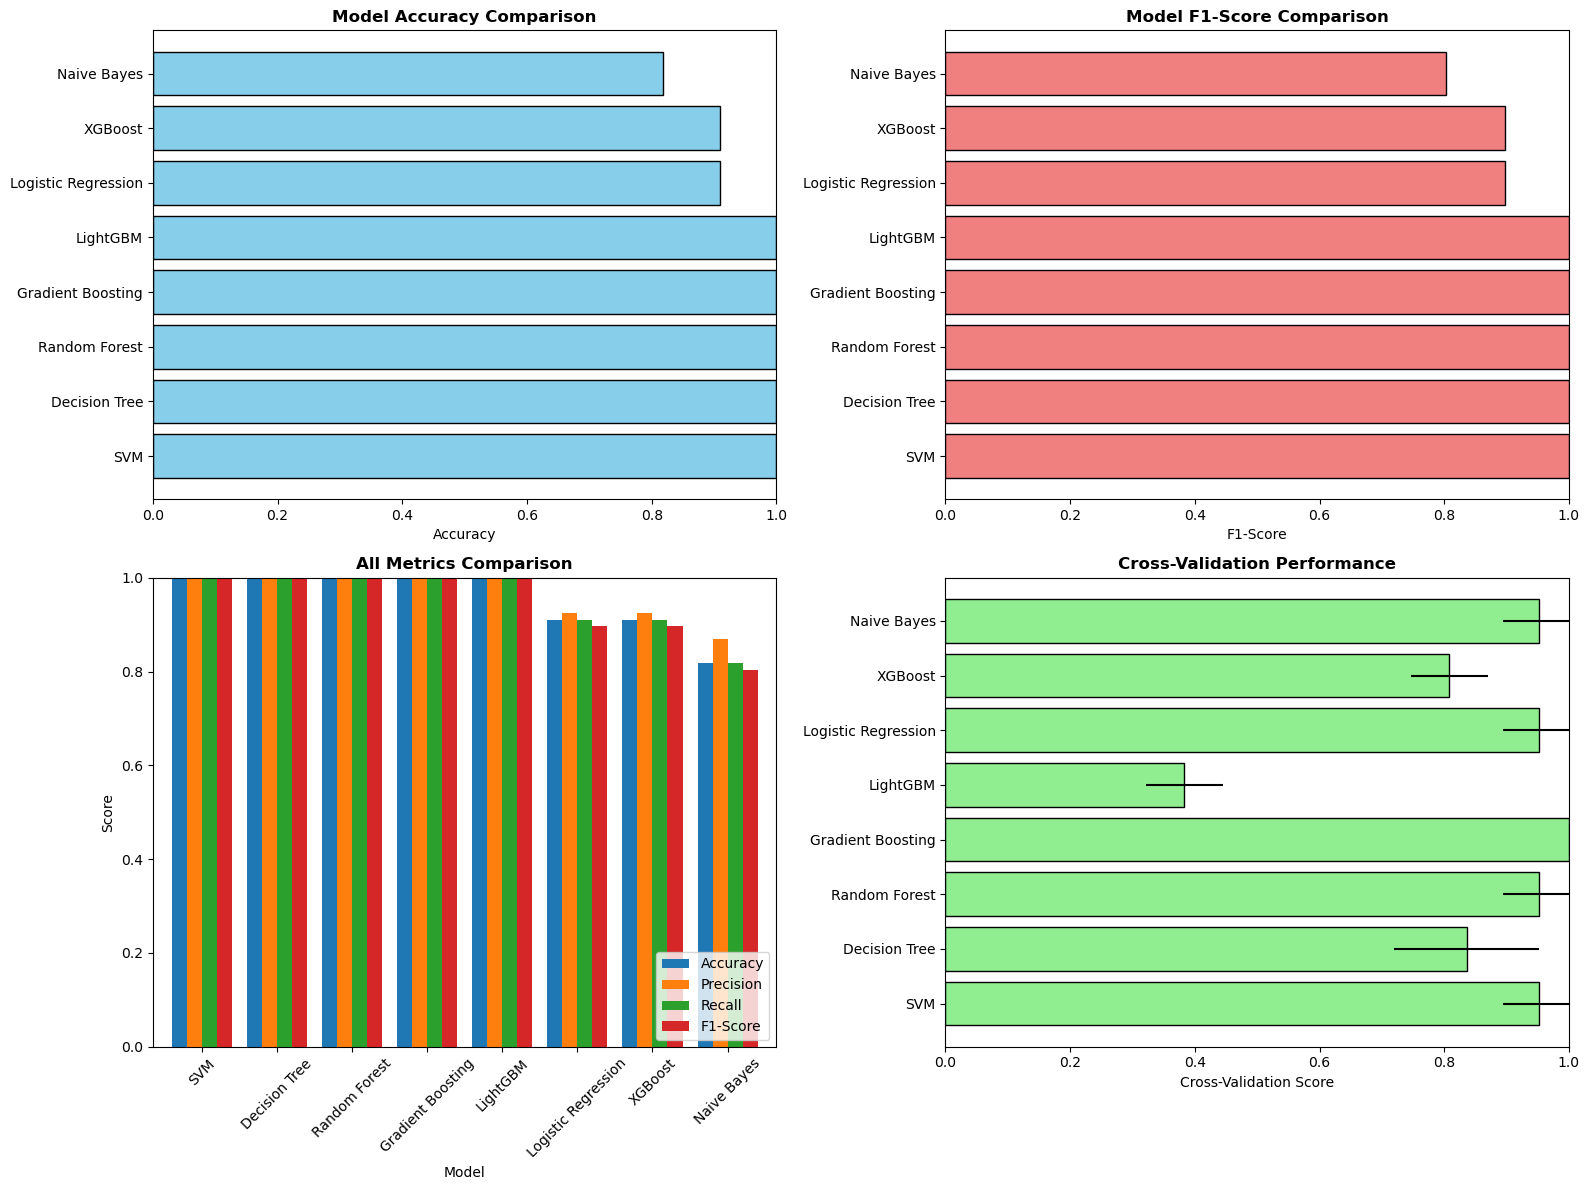

In [10]:
# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlim([0, 1])

# F1-Score comparison
axes[0, 1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison', fontweight='bold')
axes[0, 1].set_xlim([0, 1])

# All metrics comparison
metrics_df = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('All Metrics Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend(loc='lower right')
axes[1, 0].tick_params(axis='x', rotation=45)

# CV scores with error bars
axes[1, 1].barh(results_df['Model'], results_df['CV Mean'], 
                xerr=results_df['CV Std'], color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Cross-Validation Score')
axes[1, 1].set_title('Cross-Validation Performance', fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Select and Save Best Model

In [11]:
# Select best model based on accuracy
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")

# Retrain on full training data
best_model.fit(X_train_tfidf, y_train)

# Final predictions
y_pred_final = best_model.predict(X_test_tfidf)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, 
                          target_names=label_encoder.classes_))

# Save best model
joblib.dump(best_model, 'best_model.pkl')
print(f"\nBest model saved as 'best_model.pkl'")


BEST MODEL: SVM

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         2
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Best model saved as 'best_model.pkl'


## 6. Confusion Matrix

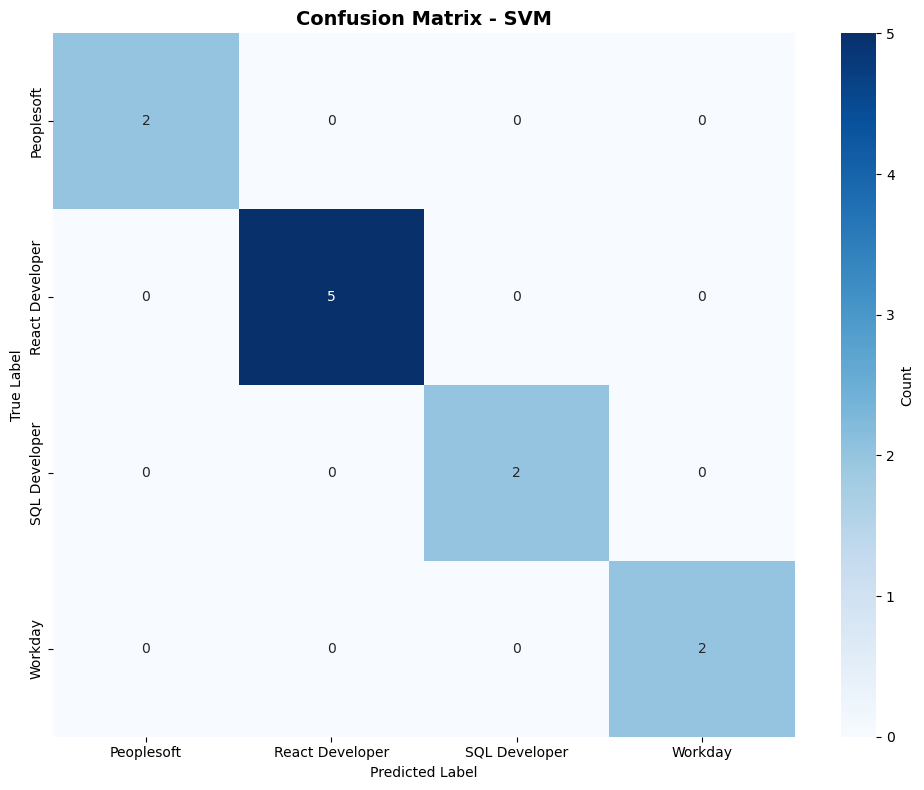

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Save Model Metadata

In [13]:
# Save results and metadata
results_df.to_csv('model_results.csv', index=False)

# Save model info
model_info = {
    'best_model': best_model_name,
    'accuracy': results_df.iloc[0]['Accuracy'],
    'f1_score': results_df.iloc[0]['F1-Score'],
    'categories': label_encoder.classes_.tolist(),
    'n_features': X_train_tfidf.shape[1],
    'train_size': len(X_train),
    'test_size': len(X_test)
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("\nModel metadata saved")
print("\nFinal Summary:")
print(json.dumps(model_info, indent=2))


Model metadata saved

Final Summary:
{
  "best_model": "SVM",
  "accuracy": 1.0,
  "f1_score": 1.0,
  "categories": [
    "Peoplesoft",
    "React Developer",
    "SQL Developer",
    "Workday"
  ],
  "n_features": 3183,
  "train_size": 42,
  "test_size": 11
}
